# Forecasting the electric power consumption of a household 

In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [94]:
url = r"household_power_consumption.txt"

df = pd.read_csv(url, sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [7]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [8]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

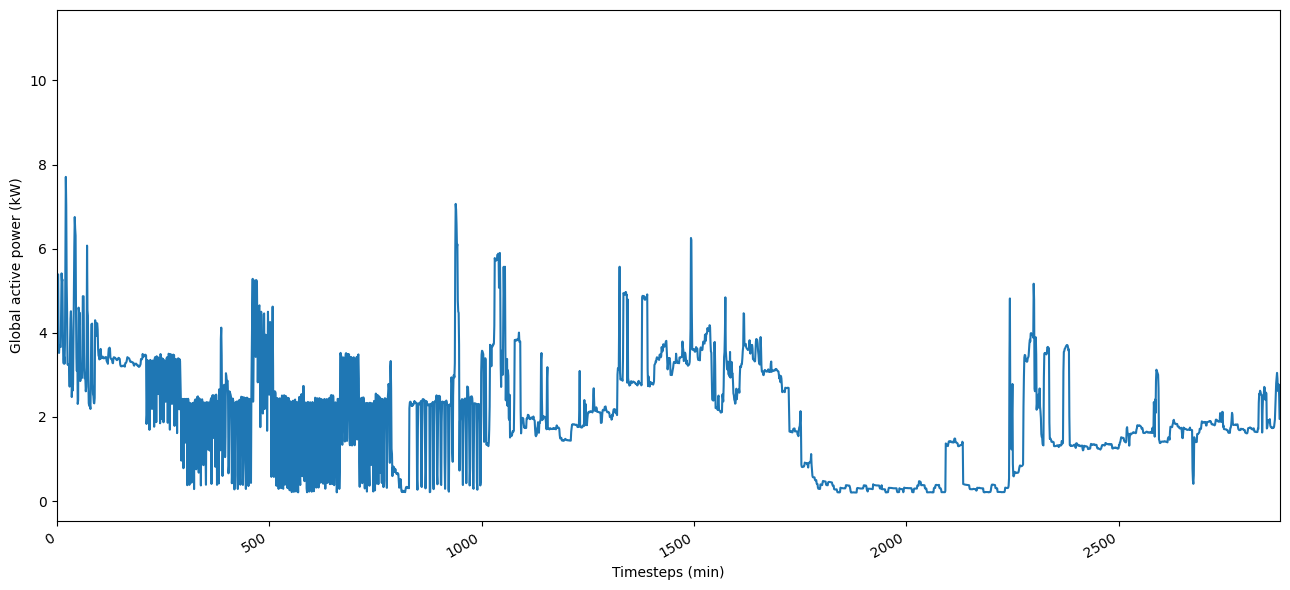

In [9]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH18_F03_peixeiro.png', dpi=300)

In [10]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [15]:
# Sample hourly sum to see if we get a more visible pattern
hourly_df = df.resample('H', on='datetime').sum()

hourly_df.head()
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
datetime,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0


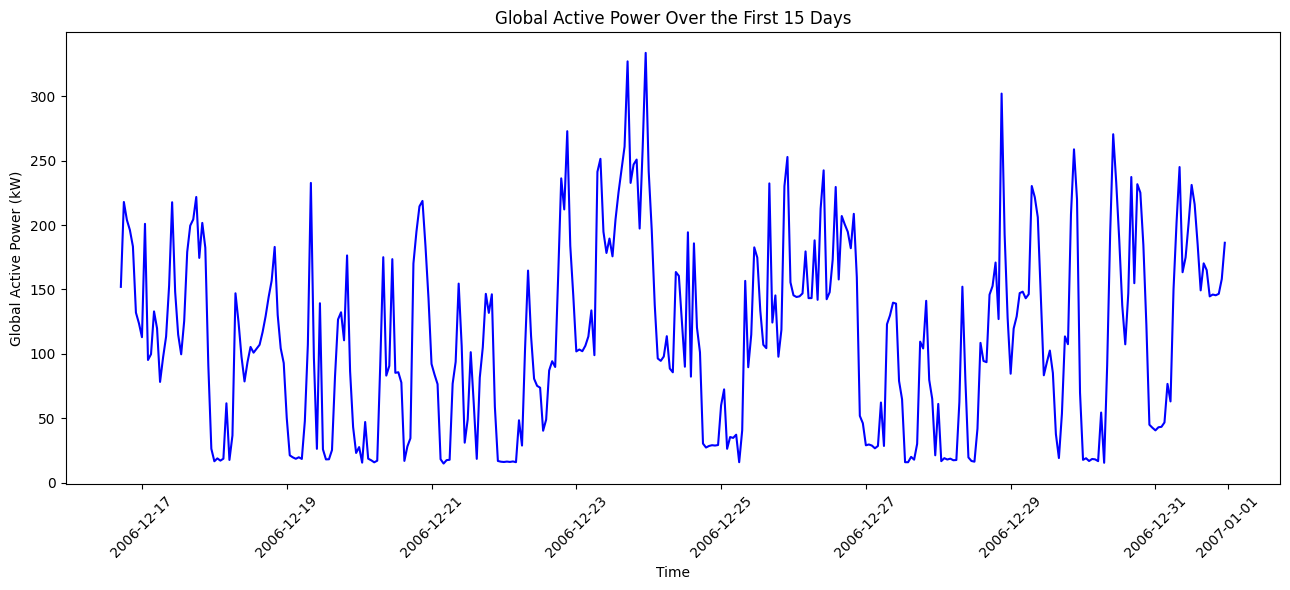

In [16]:
import matplotlib.pyplot as plt

# Filter the data for the first 15 days
first_15_days = hourly_df.loc['2006-12-16':'2006-12-31']

# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(first_15_days.index, first_15_days['Global_active_power'], label='Global Active Power', color='blue')

# Adding titles and labels
plt.title('Global Active Power Over the First 15 Days')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [14]:
# Drop first and last row of data so that we have only full 24h sums

hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
datetime,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0


In [17]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,64.674459,53.995513,0.0,20.218,46.948,94.206,393.632
Global_reactive_power,34589.0,7.329660,4.066808,0.0,4.618,6.364,8.920,46.460
Voltage,34589.0,14268.938222,1608.365811,0.0,14344.730,14455.770,14560.290,15114.120
Global_intensity,34589.0,274.178918,226.097083,0.0,89.400,200.400,393.800,1703.000
Sub_metering_2,34589.0,76.932869,250.148948,0.0,0.000,19.000,39.000,2786.000


In [18]:
timestamp_s = pd.to_datetime(hourly_df.index).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [19]:
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,19.0,0.130526,-0.991445
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0,-0.130526,-0.991445
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0,-0.382683,-0.923880
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,-0.608761,-0.793353
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0,-0.793353,-0.608761


In [20]:
n = len(hourly_df)

# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24212, 7), (6918, 7), (3459, 7))

In [21]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_2         34589 non-null  float64
 5   day_sin                34589 non-null  float64
 6   day_cos                34589 non-null  float64
dtypes: float64(7)
memory usage: 3.1 MB


In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [23]:
train_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
datetime,,,,,,,
2006-12-16 17:00:00,0.386208,0.177443,0.558893,0.382619,0.006820,0.565826,1.228295e-12
2006-12-16 18:00:00,0.553644,0.103358,0.931236,0.549618,0.144652,0.434174,1.521006e-14
2006-12-16 19:00:00,0.518286,0.110073,0.925886,0.510981,0.030869,0.307007,3.407417e-02
2006-12-16 20:00:00,0.498217,0.096987,0.929217,0.490311,0.000000,0.192993,9.990042e-02
2006-12-16 21:00:00,0.465887,0.099010,0.941472,0.459659,0.008973,0.099900,1.929928e-01


In [24]:
def prepare_features(df, lags, exogenous_vars):
    # Create lagged features for the target variable
    lagged_features = pd.DataFrame()
    for lag in range(1, lags + 1):
        lagged_features[f'lag_{lag}'] = df['Global_active_power'].shift(lag)
    
    # Add sine and cosine transformations for time features
    df['day_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['day_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    
    # Extract the exogenous variables' last day values
    exogenous_last_day = df[exogenous_vars + ['day_sin', 'day_cos']].shift(1)
    
    # Combine lagged features and exogenous variables
    combined_features = pd.concat([lagged_features, exogenous_last_day], axis=1).dropna()
    
    # Create the target variable, which is the Global_active_power with the same index as combined_features
    target = df['Global_active_power'].loc[combined_features.index]
    
    return combined_features, target

# Define your lags and exogenous variables
lags = 24 # As we are considering last day data for prediction
exogenous_vars = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2']

# Prepare features for train, validation, and test sets
train_features, train_target = prepare_features(train_df, lags, exogenous_vars)
val_features, val_target = prepare_features(val_df, lags, exogenous_vars)
test_features, test_target = prepare_features(test_df, lags, exogenous_vars)

# Check the shapes of the resulting DataFrames
train_features.shape, train_target.shape, val_features.shape, val_target.shape, test_features.shape, test_target.shape


((24188, 30), (24188,), (6894, 30), (6894,), (3435, 30), (3435,))

In [25]:
train_features_np = train_features.to_numpy()  # Convert DataFrame to NumPy array

# Reshape the array
train_features_reshaped = train_features.to_numpy().reshape((train_features.shape[0], 1, train_features.shape[1]))
val_features_reshaped = val_features.to_numpy().reshape((val_features.shape[0], 1, val_features.shape[1]))
test_features_reshaped = test_features.to_numpy().reshape((test_features.shape[0], 1, test_features.shape[1]))


In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Reshape, GRU, Bidirectional


class ModelTrainer:
    def __init__(self, patience=3, max_epochs=50):
        """
        Initialize the ModelTrainer with early stopping patience and maximum epochs.

        Parameters:
        - patience (int): Number of epochs with no improvement after which training will be stopped.
        - max_epochs (int): Maximum number of epochs to train the model.
        """
        self.patience = patience
        self.max_epochs = max_epochs

    def compile_and_fit(self, model, X_train, y_train, X_val, y_val):
        """
        Compile and fit the model using the training and validation data.

        Parameters:
        - model (tf.keras.Model): The model to compile and fit.
        - X_train (np.array): Training features.
        - y_train (np.array): Training target.
        - X_val (np.array): Validation features.
        - y_val (np.array): Validation target.

        Returns:
        - history (tf.keras.callbacks.History): History object containing training information.
        """
        # Early stopping callback to stop training when validation loss stops improving
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience, mode='min')
        
        # Compile the model with Mean Squared Error loss, Adam optimizer, and Mean Absolute Error metric
        model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
        
        # Fit the model to the training data and validate on the validation data
        history = model.fit(X_train, y_train,
                            epochs=self.max_epochs,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])
        
        return history


# Linear Model

In [27]:
from sklearn.metrics import r2_score

# Initialize the ModelTrainer class
trainer = ModelTrainer(patience=3, max_epochs=50)

# Define a linear model
linear_model = Sequential([
    Dense(1, kernel_initializer='zeros', input_shape=(train_features.shape[1],))
])

# Fit the linear model using the trainer
history = trainer.compile_and_fit(linear_model, train_features, train_target, val_features, val_target)

# Evaluate the model on the validation set
val_performance = {}
val_performance['Linear'] = linear_model.evaluate(val_features, val_target)

# Evaluate the model on the test set
performance = {}
performance['Linear'] = linear_model.evaluate(test_features, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['Linear'])
print("Test Performance (MAE):", performance['Linear'])
pred =linear_model.predict(test_features)

# Calculate R² value
r2 ={}
r2['Liner'] = r2_score(test_target, pred)


Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 0.0147 - mean_absolute_error: 0.0868 - val_loss: 0.0080 - val_mean_absolute_error: 0.0647
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - loss: 0.0088 - mean_absolute_error: 0.0661 - val_loss: 0.0077 - val_mean_absolute_error: 0.0628
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 0.0086 - mean_absolute_error: 0.0648 - val_loss: 0.0077 - val_mean_absolute_error: 0.0625
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - loss: 0.0086 - mean_absolute_error: 0.0645 - val_loss: 0.0077 - val_mean_absolute_error: 0.0624
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - loss: 0.0086 - mean_absolute_error: 0.0644 - val_loss: 0.0077 - val_mean_absolute_error: 0.0624
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - loss: 0.0086 - mean_absolute_error: 0.0644 - val_loss: 0.0077 - val_mean_absolute_error: 0.0624
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 0.0086 - mean_absolute_err

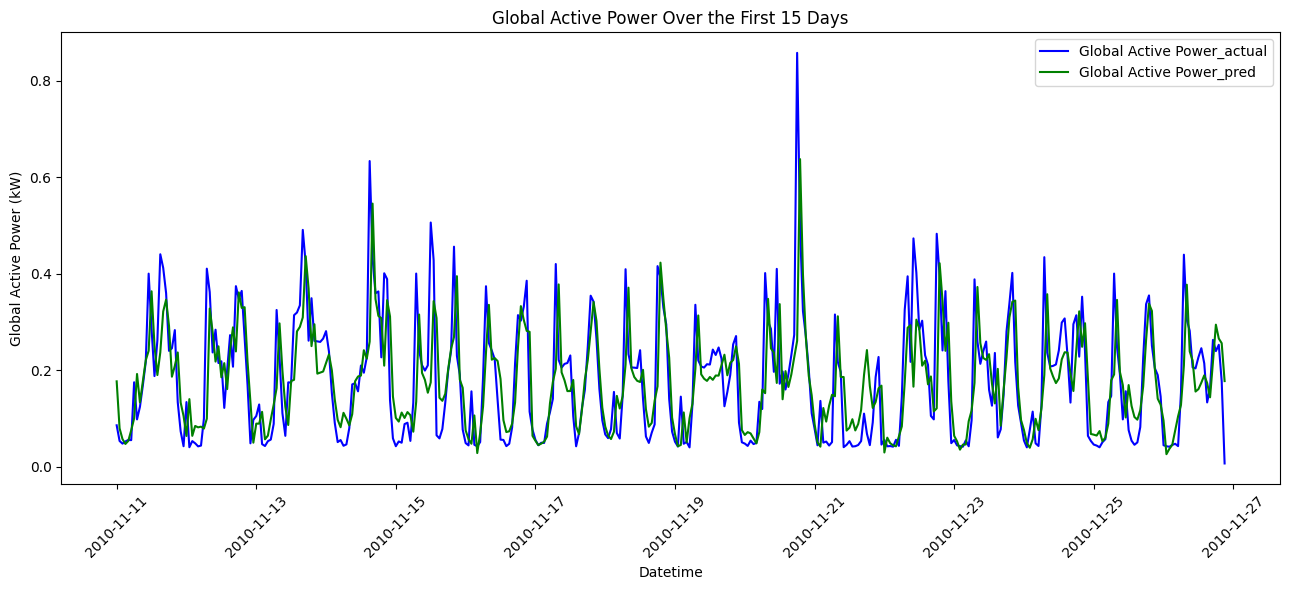

In [34]:
# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(test_target.loc['2010-11-11':].index, test_target.loc['2010-11-11':], label='Global Active Power_actual', color='blue')
plt.plot(pred.loc['2010-11-11':].index, pred.loc['2010-11-11':], label='Global Active Power_pred', color='green')


# Adding titles and labels
plt.title('Global Active Power Over the First 15 Days')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [35]:
print("train_features_reshaped.shape",train_features_reshaped.shape)
print("train_target.shape",train_target.shape)
print("train_features.shape",train_features.shape)


train_features_reshaped.shape (24188, 1, 30)
train_target.shape (24188,)
train_features.shape (24188, 30)


# LSTM Model

In [36]:
trainer = ModelTrainer(patience=3, max_epochs=50)
lstm_model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(1, 30)),  
    Dense(1)
])

# Fit the linear model using the trainer
history = trainer.compile_and_fit(lstm_model, train_features_reshaped, train_target, val_features_reshaped, val_target)

# Evaluate the model on the validation set

val_performance['LSTM'] = lstm_model.evaluate(val_features_reshaped, val_target)

performance['LSTM'] = lstm_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['LSTM'])
print("Test Performance (MAE):", performance['LSTM'])



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0787 - val_loss: 0.0076 - val_mean_absolute_error: 0.0610
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 0.0083 - mean_absolute_error: 0.0632 - val_loss: 0.0075 - val_mean_absolute_error: 0.0604
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 0.0081 - mean_absolute_error: 0.0624 - val_loss: 0.0074 - val_mean_absolute_error: 0.0601
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 0.0081 - mean_absolute_error: 0.0620 - val_loss: 0.0073 - val_mean_absolute_error: 0.0598
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - loss: 0.0080 - mean_absolute_error: 0.0617 - val_loss: 0.0073 - val_mean_absolute_error: 0.0596
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0614 - val_loss: 0.0072 - val_mean_absolute_error: 0.0594
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 0.0079 - mean_absolute_error: 

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


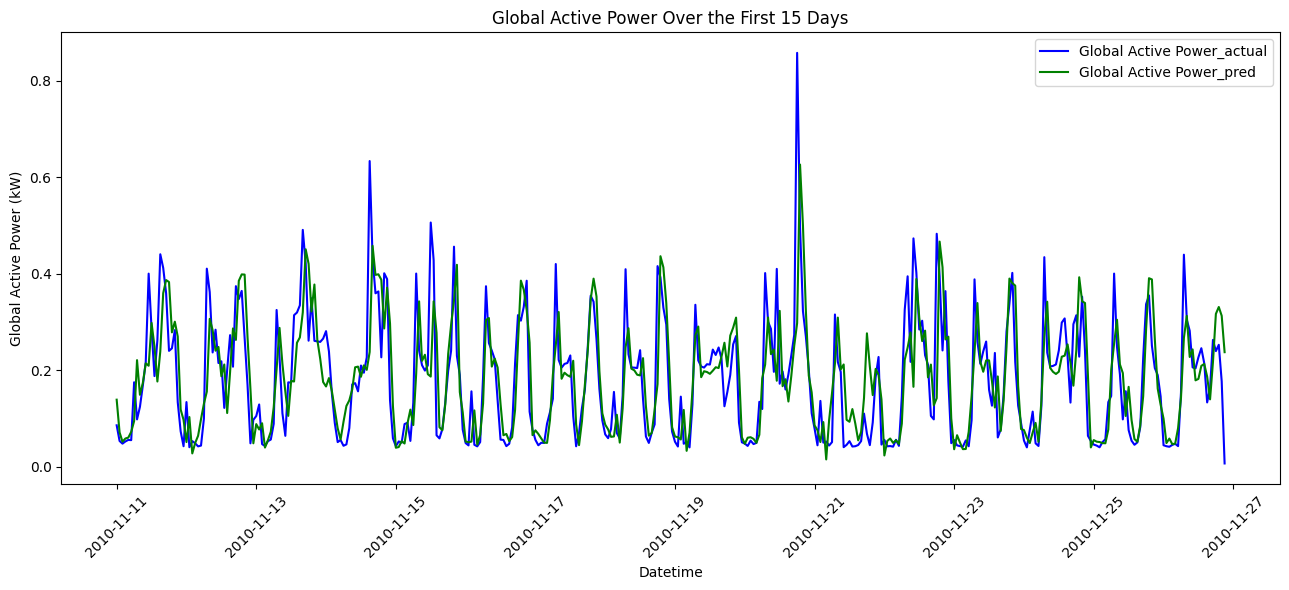

In [37]:
pred1 =lstm_model.predict(test_features_reshaped)
pred1 = pd.Series(pred1.flatten(), index=test_target.index, name="LSTM_pred")
r2['LSTM'] = r2_score(test_target, pred1)

# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(test_target.loc['2010-11-11':].index, test_target.loc['2010-11-11':], label='Global Active Power_actual', color='blue')
plt.plot(pred1.loc['2010-11-11':].index, pred1.loc['2010-11-11':], label='Global Active Power_pred', color='green')


# Adding titles and labels
plt.title('Global Active Power Over the First 15 Days')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# GRU

In [40]:
trainer = ModelTrainer(patience=3, max_epochs=50)
GRU_model = Sequential([
    GRU(32, return_sequences=True, input_shape=(1, 30)), 
    GRU(16, return_sequences=False),
    Dense(1)
])

# Fit the linear model using the trainer
history = trainer.compile_and_fit(GRU_model, train_features_reshaped, train_target, val_features_reshaped, val_target)

val_performance['GRU'] = GRU_model.evaluate(val_features_reshaped, val_target)

performance['GRU'] = GRU_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['GRU'])
print("Test Performance (MAE):", performance['GRU'])



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0112 - mean_absolute_error: 0.0751 - val_loss: 0.0077 - val_mean_absolute_error: 0.0615
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0633 - val_loss: 0.0077 - val_mean_absolute_error: 0.0611
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0626 - val_loss: 0.0076 - val_mean_absolute_error: 0.0609
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0622 - val_loss: 0.0075 - val_mean_absolute_error: 0.0606
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0618 - val_loss: 0.0075 - val_mean_absolute_error: 0.0603
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0616 - val_loss: 0.0074 - val_mean_absolute_error: 0.0601
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0613 - v

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


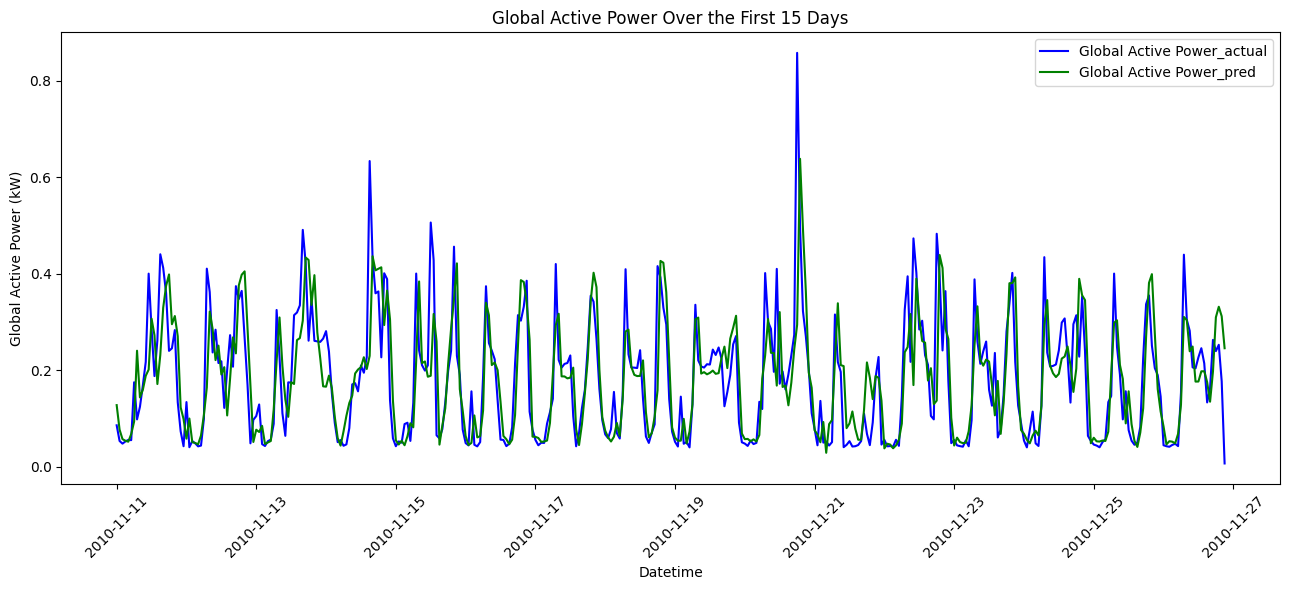

In [41]:
pred2 =GRU_model.predict(test_features_reshaped)
pred2 = pd.Series(pred2.flatten(), index=test_target.index, name="LSTM_pred")
r2['GRU'] = r2_score(test_target, pred2)

# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(test_target.loc['2010-11-11':].index, test_target.loc['2010-11-11':], label='Global Active Power_actual', color='blue')
plt.plot(pred2.loc['2010-11-11':].index, pred2.loc['2010-11-11':], label='Global Active Power_pred', color='green')


# Adding titles and labels
plt.title('Global Active Power Over the First 15 Days')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Bi LSTM

In [42]:
# Define the LSTM model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, 30)),
    Bidirectional(LSTM(16, return_sequences=False)),
    Dense(1)
])


# Fit the model using the trainer
history = trainer.compile_and_fit(
    bi_lstm_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['BiLSTM'] = bi_lstm_model.evaluate(val_features_reshaped, val_target, verbose=0)


performance['BiLSTM'] = bi_lstm_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['BiLSTM'])
print("Test Performance (MAE):", performance['BiLSTM'])

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0127 - mean_absolute_error: 0.0797 - val_loss: 0.0077 - val_mean_absolute_error: 0.0614
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0631 - val_loss: 0.0076 - val_mean_absolute_error: 0.0608
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0623 - val_loss: 0.0075 - val_mean_absolute_error: 0.0605
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0619 - val_loss: 0.0074 - val_mean_absolute_error: 0.0602
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0616 - val_loss: 0.0074 - val_mean_absolute_error: 0.0600
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0613 - val_loss: 0.0073 - val_mean_absolute_error: 0.0598
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0611 - v

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


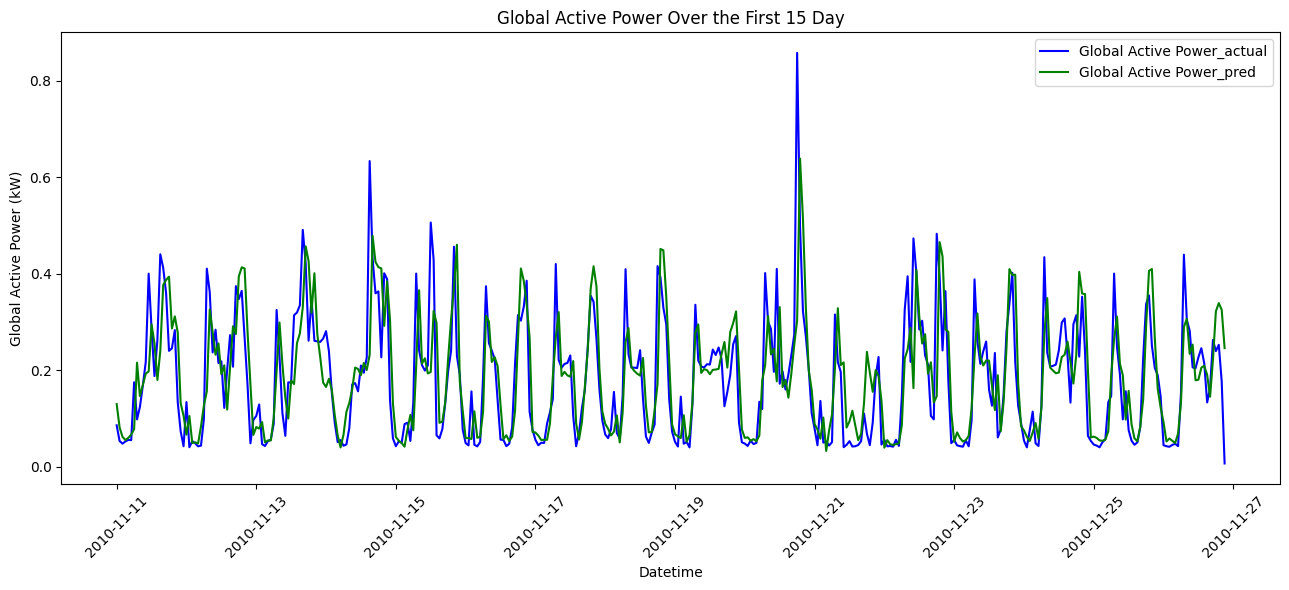

In [43]:
pred3 =bi_lstm_model.predict(test_features_reshaped)
pred3 = pd.Series(pred3.flatten(), index=test_target.index, name="BiLSTM")
r2['BiLSTM'] = r2_score(test_target, pred3)


# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(test_target.loc['2010-11-11':].index, test_target.loc['2010-11-11':], label='Global Active Power_actual', color='blue')
plt.plot(pred3.loc['2010-11-11':].index, pred3.loc['2010-11-11':], label='Global Active Power_pred', color='green')


# Adding titles and labels
plt.title('Global Active Power Over the First 15 Day')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# CNN

In [44]:

# Define the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])


# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set

val_performance['CNN'] = cnn_model.evaluate(val_features_reshaped, val_target, verbose=0)

performance['CNN'] = cnn_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN'])
print("Test Performance (MAE):", performance['CNN'])


Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0111 - mean_absolute_error: 0.0739 - val_loss: 0.0072 - val_mean_absolute_error: 0.0599
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0627 - val_loss: 0.0071 - val_mean_absolute_error: 0.0589
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0615 - val_loss: 0.0072 - val_mean_absolute_error: 0.0589
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0607 - val_loss: 0.0073 - val_mean_absolute_error: 0.0589
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0600 - val_loss: 0.0073 - val_mean_absolute_error: 0.0590
Validation Performance (Loss, MAE): [0.007285949308425188, 0.05904338136315346]
Test Performance (MAE): [0.005325334146618843, 0.04876348748803139]


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


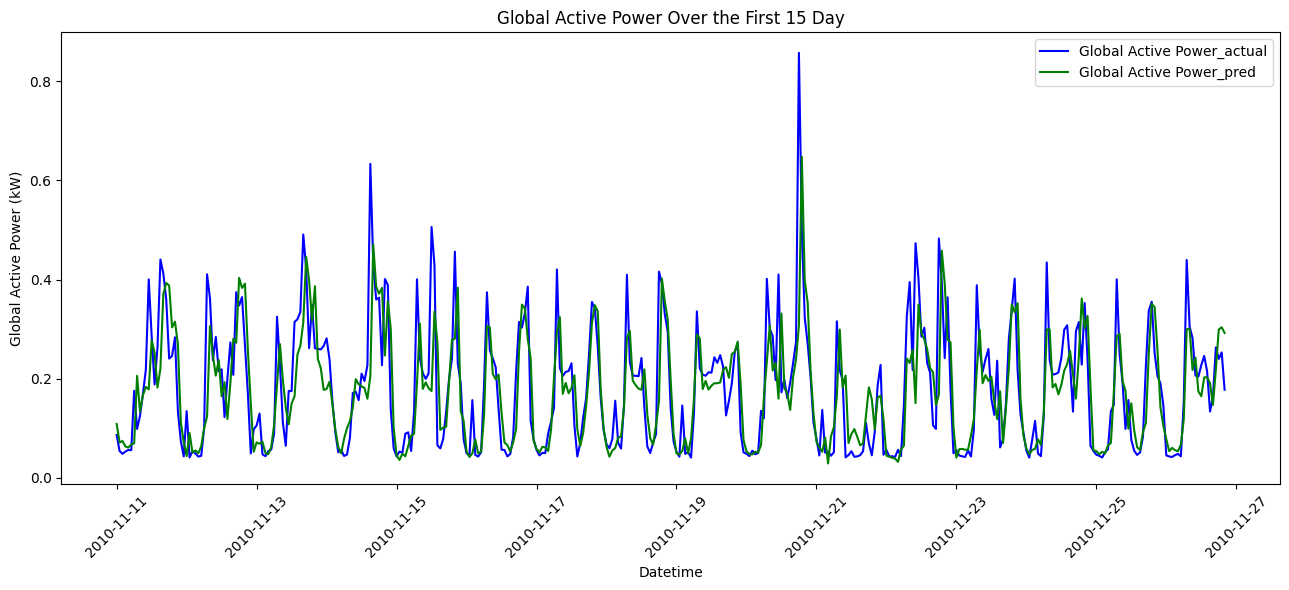

In [45]:
pred4 =cnn_model.predict(test_features_reshaped)
pred4 = pd.Series(pred4.flatten(), index=test_target.index, name="CNN")
r2['CNN'] = r2_score(test_target, pred4)

# Plot the Global_active_power
plt.figure(figsize=(13, 6))
plt.plot(test_target.loc['2010-11-11':].index, test_target.loc['2010-11-11':], label='Global Active Power_actual', color='blue')
plt.plot(pred4.loc['2010-11-11':].index, pred4.loc['2010-11-11':], label='Global Active Power_pred', color='green')


# Adding titles and labels
plt.title('Global Active Power Over the First 15 Day')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


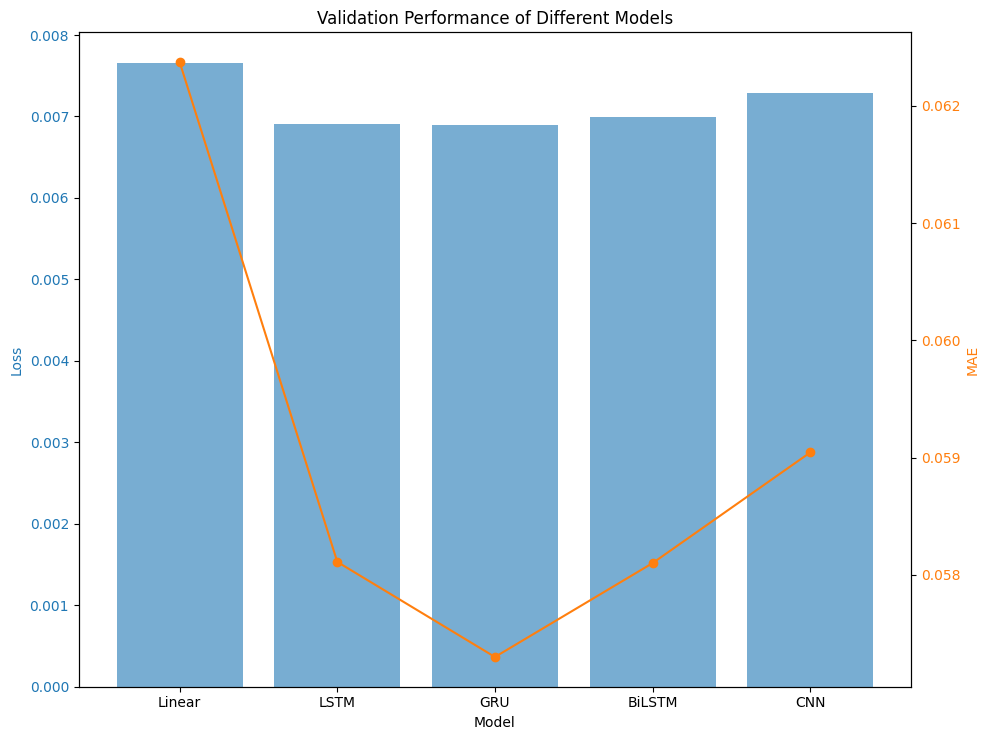

In [45]:
import matplotlib.pyplot as plt


# Extract data from dictionary
models = list(val_performance.keys())
losses = [val[0] for val in val_performance.values()]
maes = [val[1] for val in val_performance.values()]

# Create the bar plot
fig, ax1 = plt.subplots()

# Plot Loss
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss', color=color)
ax1.bar(models, losses, color=color, alpha=0.6, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot MAE
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('MAE', color=color)
ax2.plot(models, maes, color=color, marker='o', label='MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show the plot
plt.title('Validation Performance of Different Models')
fig.tight_layout()
plt.show()


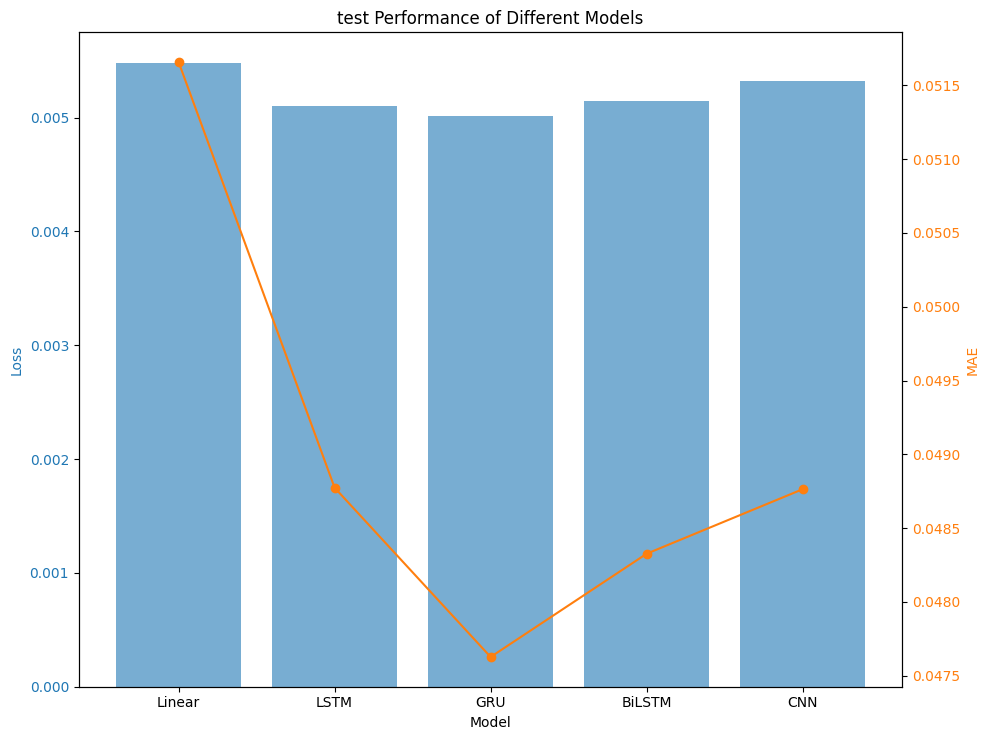

In [46]:
import matplotlib.pyplot as plt


# Extract data from dictionary
models = list(performance.keys())
losses = [loss[0] for loss in performance.values()]
maes = [mae[1] for mae in performance.values()]

# Create the bar plot
fig, ax1 = plt.subplots()

# Plot Loss
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss', color=color)
ax1.bar(models, losses, color=color, alpha=0.6, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot MAE
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('MAE', color=color)
ax2.plot(models, maes, color=color, marker='o', label='MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show the plot
plt.title('test Performance of Different Models')
fig.tight_layout()
plt.show()


# CNN-BiLSTM

In [47]:
# Define the CNN+BiLSTM hybrid model
cnn_bilstm_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_bilstm_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['CNN+BiLSTM'] = cnn_bilstm_model.evaluate(val_features_reshaped, val_target, verbose=0)

# Evaluate the model on the test set
performance['CNN+BiLSTM'] = cnn_bilstm_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+BiLSTM'])
print("Test Performance (MAE):", performance['CNN+BiLSTM'])

# Make predictions
pred_cnn_bilstm = cnn_bilstm_model.predict(test_features_reshaped)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0125 - mean_absolute_error: 0.0786 - val_loss: 0.0072 - val_mean_absolute_error: 0.0590
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0614 - val_loss: 0.0073 - val_mean_absolute_error: 0.0585
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0604 - val_loss: 0.0074 - val_mean_absolute_error: 0.0584
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0598 - val_loss: 0.0074 - val_mean_absolute_error: 0.0585
Validation Performance (Loss, MAE): [0.0074333795346319675, 0.05846438929438591]
Test Performance (MAE): [0.005353329237550497, 0.04767598584294319]
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [50]:
# Calculate the R² value for the CNN+BiLSTM model
r2['CNN+BiLSTM'] = r2_score(test_target, pred_cnn_bilstm)
print("R² value on the test set (CNN+BiLSTM):", r2['CNN+BiLSTM'])

R² value on the test set (CNN+BiLSTM): 0.5802772254534678


# CNN +LSTM

In [51]:
# Define the CNN+LSTM hybrid model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_lstm_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(val_features_reshaped, val_target, verbose=0)

# Evaluate the model on the test set
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+LSTM'])
print("Test Performance (MAE):", performance['CNN+LSTM'])

# Make predictions
pred_cnn_lstm = cnn_lstm_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+LSTM model
r2['CN+LSTM'] = r2_score(test_target, pred_cnn_lstm)


Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0120 - mean_absolute_error: 0.0771 - val_loss: 0.0072 - val_mean_absolute_error: 0.0590
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0616 - val_loss: 0.0072 - val_mean_absolute_error: 0.0581
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0605 - val_loss: 0.0073 - val_mean_absolute_error: 0.0583
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0598 - val_loss: 0.0074 - val_mean_absolute_error: 0.0582
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0593 - val_loss: 0.0073 - val_mean_absolute_error: 0.0580
Validation Performance (Loss, MAE): [0.007347628939896822, 0.05802640691399574]
Test Performance (MAE): [0.0053157443180680275, 0.046894621104002]
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# CNN + GRU

In [52]:
from tensorflow.keras.layers import GRU

# Define the CNN+GRU hybrid model
cnn_gru_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    GRU(32, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_gru_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['CNN+GRU'] = cnn_gru_model.evaluate(val_features_reshaped, val_target, verbose=0)

# Evaluate the model on the test set
performance['CNN+GRU'] = cnn_gru_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+GRU'])
print("Test Performance (MAE):", performance['CNN+GRU'])

# Make predictions
pred_cnn_gru = cnn_gru_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+GRU model
r2["CNN+GRU"] = r2_score(test_target, pred_cnn_gru)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.0745 - val_loss: 0.0072 - val_mean_absolute_error: 0.0599
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0616 - val_loss: 0.0073 - val_mean_absolute_error: 0.0588
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0604 - val_loss: 0.0073 - val_mean_absolute_error: 0.0585
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0597 - val_loss: 0.0074 - val_mean_absolute_error: 0.0582
Validation Performance (Loss, MAE): [0.007376514840871096, 0.058196667581796646]
Test Performance (MAE): [0.005317893344908953, 0.04707461968064308]
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# CNN + BiGRU

In [53]:
# Define the CNN+BiGRU hybrid model
cnn_bigru_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    Bidirectional(GRU(32, return_sequences=True)),
    Bidirectional(GRU(32, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_bigru_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['CNN+BiGRU'] = cnn_bigru_model.evaluate(val_features_reshaped, val_target, verbose=0)

# Evaluate the model on the test set
performance['CNN+BiGRU'] = cnn_bigru_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+BiGRU'])
print("Test Performance (MAE):", performance['CNN+BiGRU'])

# Make predictions
pred_cnn_bigru = cnn_bigru_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+BiGRU model
r2['CNN+BiGRU'] = r2_score(test_target, pred_cnn_bigru)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0111 - mean_absolute_error: 0.0739 - val_loss: 0.0071 - val_mean_absolute_error: 0.0590
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0618 - val_loss: 0.0070 - val_mean_absolute_error: 0.0585
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0607 - val_loss: 0.0071 - val_mean_absolute_error: 0.0577
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0599 - val_loss: 0.0071 - val_mean_absolute_error: 0.0573
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0594 - val_loss: 0.0072 - val_mean_absolute_error: 0.0574
Validation Performance (Loss, MAE): [0.007178547326475382, 0.05739976465702057]
Test Performance (MAE): [0.005228616762906313, 0.04703135788440704]
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# CNN + LSTM + GRU

In [54]:
# Define the CNN+LSTM+GRU hybrid model
cnn_lstm_gru_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    LSTM(32, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_lstm_gru_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation set
val_performance['CNN+LSTM+GRU'] = cnn_lstm_gru_model.evaluate(val_features_reshaped, val_target, verbose=0)

# Evaluate the model on the test set
performance['CNN+LSTM+GRU'] = cnn_lstm_gru_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+LSTM+GRU'])
print("Test Performance (MAE):", performance['CNN+LSTM+GRU'])

# Make predictions
pred_cnn_lstm_gru = cnn_lstm_gru_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+LSTM+GRU model
r2["cnn_lstm_gru"] = r2_score(test_target, pred_cnn_lstm_gru)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0776 - val_loss: 0.0072 - val_mean_absolute_error: 0.0592
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0613 - val_loss: 0.0073 - val_mean_absolute_error: 0.0586
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0603 - val_loss: 0.0073 - val_mean_absolute_error: 0.0584
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0597 - val_loss: 0.0073 - val_mean_absolute_error: 0.0583
Validation Performance (Loss, MAE): [0.007349932100623846, 0.05832741782069206]
Test Performance (MAE): [0.005318201147019863, 0.047250084578990936]
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# CNN + BiLSTM + Dense

In [71]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotUniform, he_normal, he_uniform
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout1D

# Define the CNN+BiLSTM hybrid model
cnn_bilstm_dense_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=l2(0.01),input_shape=(1, 30)),
    MaxPooling1D(pool_size=1),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_bilstm_dense_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)


# Evaluate the model on the validation and test sets
val_performance['CNN+BiLSTM+Dense'] = cnn_bilstm_dense_model.evaluate(val_features_reshaped, val_target, verbose=0)
performance['CNN+BiLSTM+Dense'] = cnn_bilstm_dense_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+BiLSTM+Dense'])
print("Test Performance (MAE):", performance['CNN+BiLSTM+Dense'])

# Make predictions
pred_cnn_bilstm_dense = cnn_bilstm_dense_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+BiLSTM+Dense model
r2['cnn_bilstm_dense'] = r2_score(test_target, pred_cnn_bilstm_dense)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.8238 - mean_absolute_error: 0.0884 - val_loss: 0.0100 - val_mean_absolute_error: 0.0669
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0733 - val_loss: 0.0101 - val_mean_absolute_error: 0.0722
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0115 - mean_absolute_error: 0.0725 - val_loss: 0.0095 - val_mean_absolute_error: 0.0702
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0721 - val_loss: 0.0091 - val_mean_absolute_error: 0.0691
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0708 - val_loss: 0.0089 - val_mean_absolute_error: 0.0666
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0705 - val_loss: 0.0087 - val_mean_absolute_error: 0.0653
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109 - mean_absolute_error: 0.0703 - v

In [73]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import BatchNormalization

# Define the CNN+BiLSTM hybrid model
cnn_bigru_bn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=l2(0.01),input_shape=(1, 30)),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32, return_sequences=False)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    cnn_bigru_bn_model, 
    train_features_reshaped, 
    train_target, 
    val_features_reshaped, 
    val_target
)

# Evaluate the model on the validation and test sets
val_performance['CNN+LSTM+GRU+BN'] = cnn_bigru_bn_model.evaluate(val_features_reshaped, val_target, verbose=0)
performance['CNN+LSTM+GRU+BN'] = cnn_bigru_bn_model.evaluate(test_features_reshaped, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['CNN+LSTM+GRU+BN'])
print("Test Performance (MAE):", performance['CNN+LSTM+GRU+BN'])

# Make predictions
pred_cnn_bigru_bn = cnn_bigru_bn_model.predict(test_features_reshaped)

# Calculate the R² value for the CNN+LSTM+GRU+BN model
r2['cnn_lstm_gru_bn'] = r2_score(test_target, pred_cnn_bigru_bn)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.8842 - mean_absolute_error: 0.0908 - val_loss: 0.0103 - val_mean_absolute_error: 0.0669
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0114 - mean_absolute_error: 0.0707 - val_loss: 0.0087 - val_mean_absolute_error: 0.0635
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.0629
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0631
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0687 - val_loss: 0.0089 - val_mean_absolute_error: 0.0643
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0687 - val_loss: 0.0089 - val_mean_absolute_error: 0.0633
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0683 - v

# DNN

In [75]:
# Define the CNN+BiLSTM hybrid model
dnn_model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    BatchNormalization(),    
    Dense(1)
])

# Fit the model using the trainer
history = trainer.compile_and_fit(
    dnn_model, 
    train_features, 
    train_target, 
    val_features, 
    val_target
)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.9450 - mean_absolute_error: 0.5641 - val_loss: 0.1756 - val_mean_absolute_error: 0.0985
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0978 - mean_absolute_error: 0.1099 - val_loss: 0.0122 - val_mean_absolute_error: 0.0679
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0145 - mean_absolute_error: 0.0774 - val_loss: 0.0112 - val_mean_absolute_error: 0.0686
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0143 - mean_absolute_error: 0.0793 - val_loss: 0.0124 - val_mean_absolute_error: 0.0755
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.0824 - val_loss: 0.0127 - val_mean_absolute_error: 0.0717
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.0843 - val_loss: 0.0123 - val_mean_absolute_error: 0.0740


In [78]:
# Evaluate the model on the validation and test sets
val_performance['DNN'] = dnn_model.evaluate(val_features, val_target, verbose=0)
performance['DNN'] = dnn_model.evaluate(test_features, test_target, verbose=0)

print("Validation Performance (Loss, MAE):", val_performance['DNN'])
print("Test Performance (MAE):", performance['DNN'])

# Make predictions
pred_dnn = dnn_model.predict(test_features)

# Calculate the R² value for the CNN+LSTM+GRU+BN model
r2['DNN'] = r2_score(test_target, pred_dnn)


Validation Performance (Loss, MAE): [0.012270954437553883, 0.07403312623500824]
Test Performance (MAE): [0.009269903413951397, 0.06128908321261406]
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [79]:
r2

{'Liner': 0.5707566714076547,
 'LSTM': 0.5999067026111686,
 'GRU': 0.6067017734589493,
 'BiLSTM': 0.5967253567150127,
 'CNN+BiLSTM': 0.5802772254534678,
 'CN+LSTM': 0.5832241278670794,
 'CNN+GRU': 0.5830554978837497,
 'CNN+BiGRU': 0.5900552292431387,
 'cnn_lstm_gru': 0.5830314710262589,
 'cnn_bilstm_dense': 0.5157455617736704,
 'cnn_lstm_gru_bn': 0.4882234377134622,
 'DNN': 0.46672082996971087}

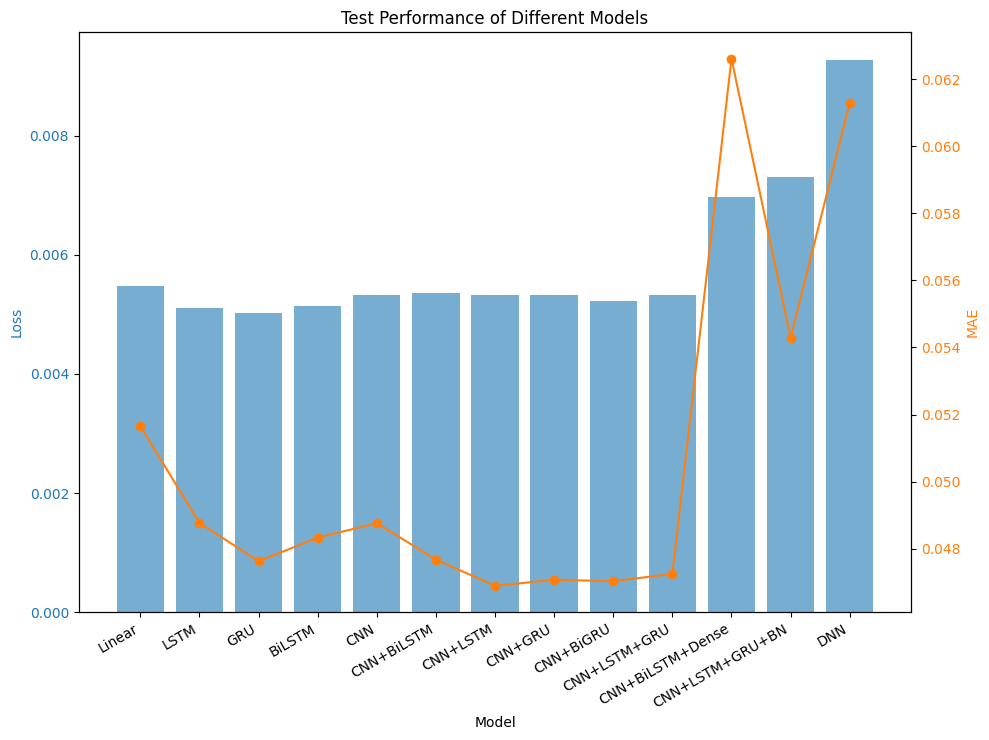

In [84]:
# Extract data from dictionary
models = list(val_performance.keys())
losses = [val[0] for val in performance.values()]
maes = [val[1] for val in performance.values()]

# Create the bar plot
fig, ax1 = plt.subplots()

# Plot Loss
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss', color=color)
ax1.bar(models, losses, color=color, alpha=0.6, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot MAE
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('MAE', color=color)
ax2.plot(models, maes, color=color, marker='o', label='MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels by 30 degrees
ax1.set_xticklabels(models, rotation=30, ha='right')

# Add title and show the plot
plt.title('Test Performance of Different Models')
fig.tight_layout()
plt.show()


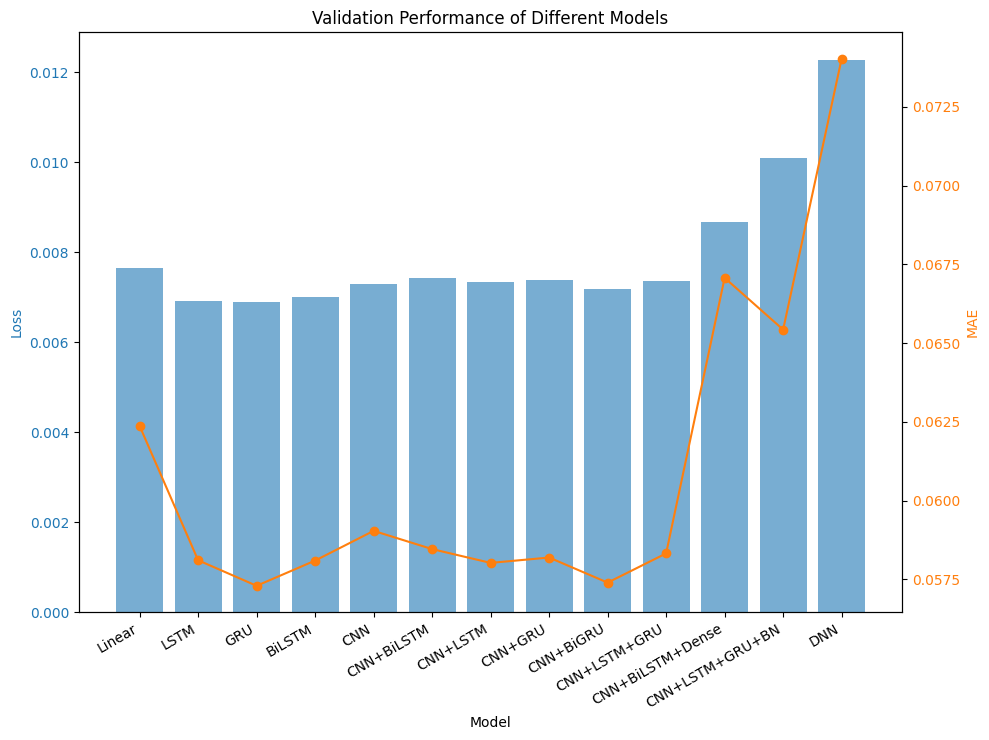

In [85]:
# Extract data from dictionary
models = list(val_performance.keys())
losses = [val[0] for val in val_performance.values()]
maes = [val[1] for val in val_performance.values()]

# Create the bar plot
fig, ax1 = plt.subplots()

# Plot Loss
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss', color=color)
ax1.bar(models, losses, color=color, alpha=0.6, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot MAE
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('MAE', color=color)
ax2.plot(models, maes, color=color, marker='o', label='MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels by 30 degrees
ax1.set_xticks(range(len(models)))  # Ensure we set the ticks at the correct positions
ax1.set_xticklabels(models, rotation=30, ha='right')

# Add title and show the plot
plt.title('Validation Performance of Different Models')
fig.tight_layout()
plt.show()


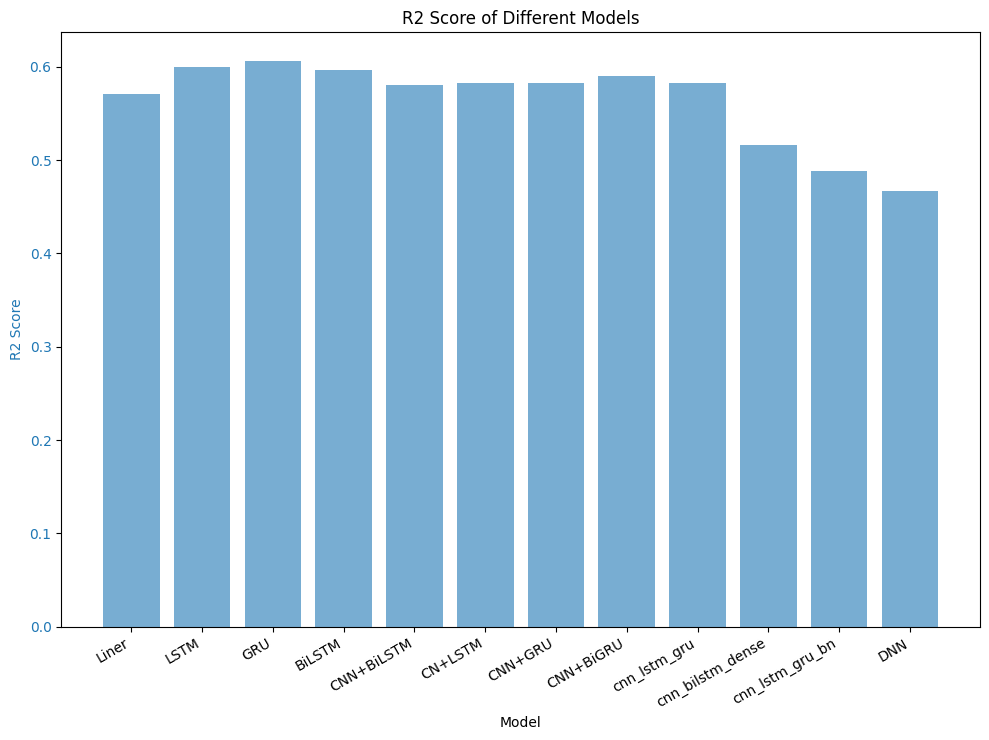

In [86]:
# Extract data from dictionary
models = list(r2.keys())
scores = [score for score in r2.values()]

# Create the bar plot
fig, ax1 = plt.subplots()

# Plot R2 scores
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('R2 Score', color=color)
ax1.bar(models, scores, color=color, alpha=0.6, label='Scores')
ax1.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels by 30 degrees
ax1.set_xticks(range(len(models)))  # Ensure we set the ticks at the correct positions
ax1.set_xticklabels(models, rotation=30, ha='right')

# Add title and show the plot
plt.title('R2 Score of Different Models')
fig.tight_layout()
plt.show()


In [91]:
# Function to find the best model based on test loss, test MAE, and R² score
def find_best_model(test_perf, val_perf, r2_scores):
    # Initialize the best model variables
    best_model = None
    best_loss = float('inf')
    best_mae = float('inf')
    best_r2 = -float('inf')
    
    for model in test_perf.keys():
        test_loss, test_mae = test_perf[model]
        val_loss, val_mae = val_perf[model]
        r2_score = r2_scores.get(model, -float('inf'))
        
        # Update best model based on lowest test loss, lowest test MAE, and highest R² score
        if test_loss < best_loss and test_mae < best_mae and r2_score > best_r2:
            best_model = model
            best_loss = test_loss
            best_mae = test_mae
            best_r2 = r2_score
    
    return best_model, best_loss, best_mae, best_r2

# Find the best model
best_model, best_loss, best_mae, best_r2 = find_best_model(performance, val_performance, r2)

# Print the results
print(f"Best Model: {best_model}")
print(f"Test Loss: {best_loss}")  # least is best
print(f"Test MAE: {best_mae}")    # least is best
print(f"R² Score: {best_r2}")     # high is best

Best Model: GRU
Test Loss: 0.0050163003616034985
Test MAE: 0.04762684926390648
R² Score: 0.6067017734589493
